In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

from scipy import stats
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('../data/train_mod.csv')
test = pd.read_csv('../data/test_mod.csv')

test_id = test['id']

In [240]:
X = train.drop(['loan_status', 'id'], axis=1)
y = train['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

vars_cat = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
vars_num = X_train.select_dtypes(include=['float64', 'int64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, vars_num),
    ('cat', categorical_transformer, vars_cat),
])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

In [241]:
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

param_dist = {'learning_rate': stats.uniform(0.01, 0.99),
              'max_depth': stats.randint(2, 12),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'n_estimators': stats.randint(50, 1000),
              'reg_lambda': stats.uniform(0.0001, 1),
              'reg_alpha': stats.uniform(0.0001, 1)
              }

classifier = LGBMClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
lgbm = RandomizedSearchCV(classifier,param_dist,cv=cv, verbose=1,scoring='roc_auc',n_iter=10,random_state=42)

lgbm.fit(X_train,y_train)
print(f'AUC CV: {round(lgbm.best_score_,2)}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 5366, number of negative: 32166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 37532, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142971 -> initscore=-1.790827
[LightGBM] [Info] Start training from score -1.790827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [242]:
lgbm.best_params_

{'colsample_bytree': np.float64(0.550499251969543),
 'learning_rate': np.float64(0.023132311548267864),
 'max_depth': 10,
 'n_estimators': 365,
 'reg_alpha': np.float64(0.5633882178455393),
 'reg_lambda': np.float64(0.3855165025399161),
 'subsample': np.float64(0.1159662522202142)}

In [243]:
lgbm = LGBMClassifier(
    **lgbm.best_params_, 
    random_state=42
)

# Train the model on the training set
lgbm.fit(X_train, y_train)

# Predictions (classes) and probabilities on the test set
y_pred = lgbm.predict(X_val)  
y_pred_prob = lgbm.predict_proba(X_val)[:, 1]  

# Model evaluation
auc_score = roc_auc_score(y_val, y_pred_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 6708, number of negative: 40208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142979 -> initscore=-1.790765
[LightGBM] [Info] Start training from score -1.790765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
AUC-ROC Score: 0.9588
Accuracy Score: 0.9532

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.91      0.74      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95     

In [244]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1_score = f1_score(y_val, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

Accuracy: 0.9531929405746441
Precision: 0.9519403979048959
Recall: 0.9531929405746441
F1 Score: 0.9510697202733165


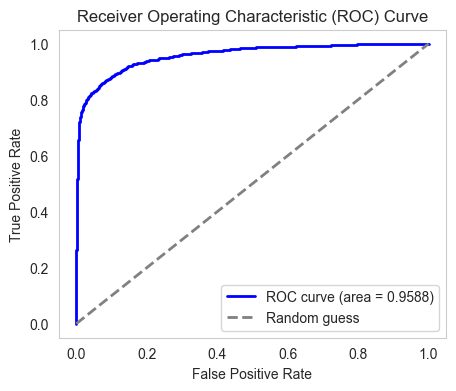

In [254]:
y_prob = lgbm.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

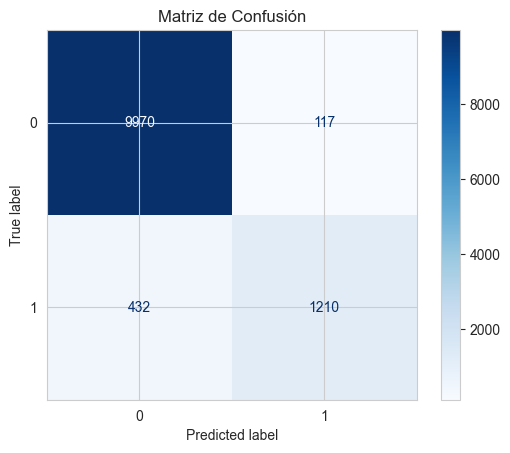

In [246]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

In [247]:
test = preprocessor.transform(test)

y_pred_prob = lgbm.predict_proba(test)[:,1]
predictions = pd.DataFrame(y_pred_prob)


predictions = predictions.reset_index().rename(columns={
    'index':'id',
    0:'loan_status'
})

predictions['id'] = test_id

In [248]:
y_pred_prob

array([0.97548443, 0.0255347 , 0.53944724, ..., 0.01765843, 0.32749789,
       0.94750674])

In [ ]:
predictions.to_csv("light_gbm_proba_features.csv", index=False)

In [250]:
num_features = vars_num

# Recuperar nombres de las columnas categóricas (OneHotEncoded)
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(vars_cat)

# Combinar todos los nombres de columnas procesadas
all_features = list(num_features) + list(cat_features)

X_train_df = pd.DataFrame(X_train, columns=all_features)
X_val_df = pd.DataFrame(X_val, columns=all_features)

feature_importances = lgbm.feature_importances_

# Crear un DataFrame con las importancias
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Ordenar por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

Text(0.5, 1.0, 'Feature Importance Rank')

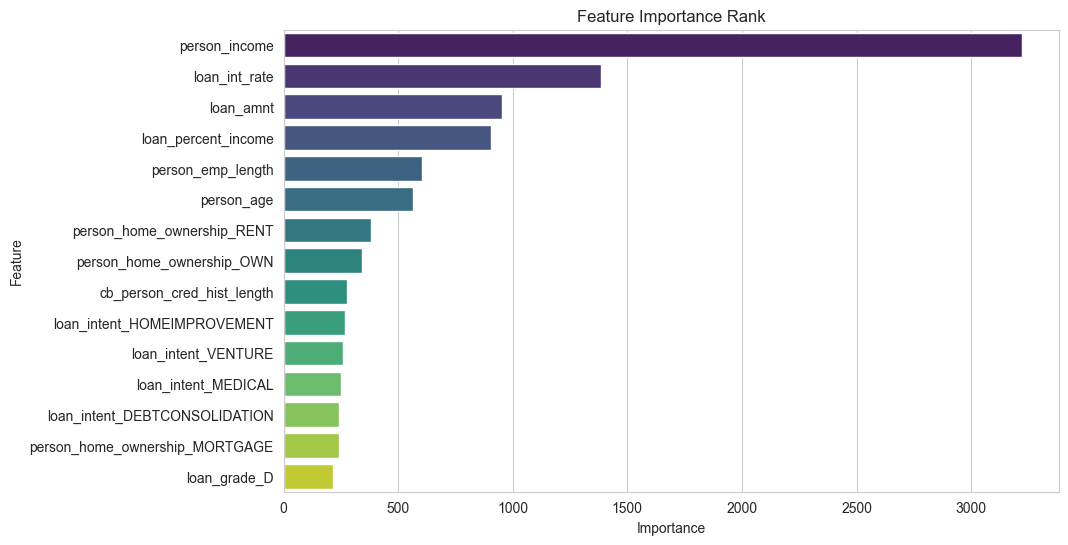

In [251]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Feature Importance Rank')


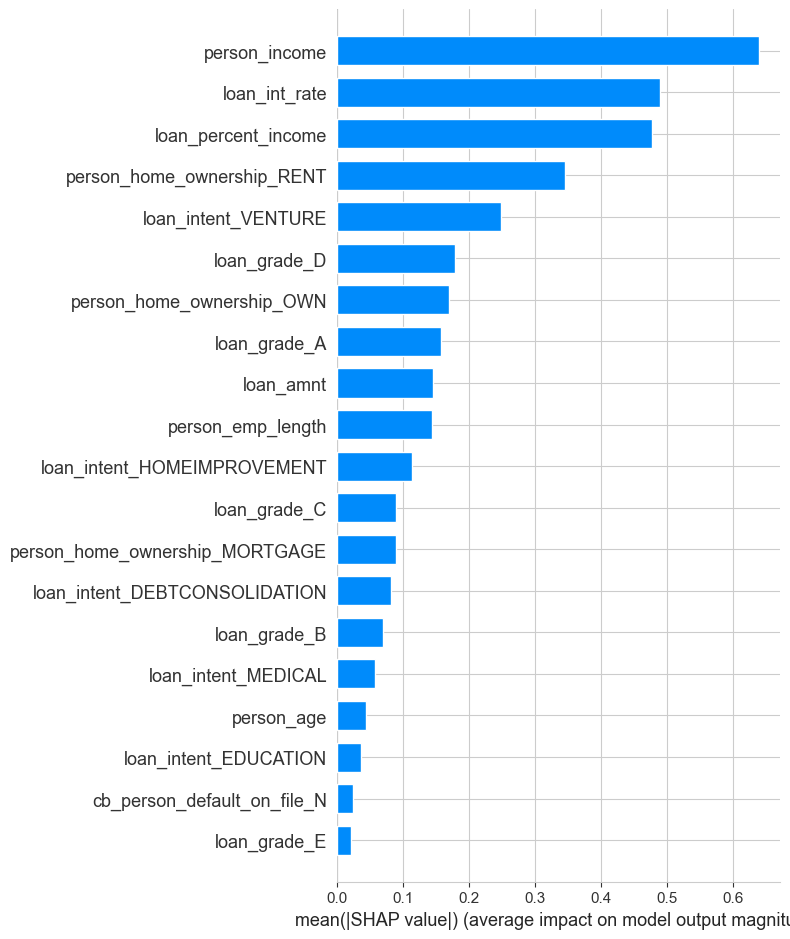

In [252]:
import shap
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer(X_val_df)
shap.summary_plot(shap_values, X_val_df, plot_type="bar")

In [253]:
print(f'Caso con mayor probabilidad: {y_pred_prob.argmax()}')
print(f'Score: {y_pred_prob.max()}')

Caso con mayor probabilidad: 20076
Score: 0.9969680486083907
